In [7]:
from turtle import pos
from theoric import *
from practical import *
from practical.data import *
import matplotlib.pyplot as plt
import osmnx.distance as distance
import osmnx as ox
import os.path

# Projet RO - Optimisation Hivernale
Dans ce projet, nous allons comprendre comment optimiser le déneigement de la ville de Montréal.

Cette démonstration comporte 3 parties:
* Analyse du problème
* Parcours du Drone
    * Théorie
    * Pratique
* Parcours de la Déneigeuse
    * Théorie
    * Pratique
* Modèle de Coût
* Conclusion

Nous allons commencer par définir le vocabulaire que nous utiliserons dans ce notebook :

* Un node : un nœud du graphe
* Un edge : l’axe qui relie deux node entre eux

En première partie nous allons nous occuper du trajet du drone. Pour cela nous considérons donc un graphe non orienté car le drone n’a pas besoin de suivre le sens de la circulation (et que c’est plus simple !). Nous sommes partis du principe que notre graphe est connexe. En effet, si toutes les rues d’une ville ne sont pas reliées ce n’est pas une ville… Nous parcourons donc le graphe avec le drone. Nous envoyons un drone survoler les rues pour savoir combien de centimètres de neige il y a sur chaque rue. Cela va nous servir pour définir les rues prioritaires au déneigement.




Une fois que le parcours du graphe par le drone est acté, nous pouvons passer au parcours de la déneigeuse. Celle-ci doit en revanche suivre les sens de circulation, nous allons donc avoir besoin d’un graphe orienté. Nous allons à partir d’ici utiliser la bibliothèque OSMNX qui nous permet de transformer n’importe quel plan de ville en graphe orienté grâce à l’attribut graph_from_place(). Nous devons ajouter le paramètre « drive » car la vitesse de déplacement de la déneigeuse se rapproche plus de celle d’une voiture que de celle d’un passant. 



A partir de ce graphe, nous allons créer un graphe Eulérien. Pourquoi ? Parce que cela permet de passer par toutes les routes du graphe d’un seul coup sans passer des points plusieurs fois, en somme ça nous permet d’optimiser notre solution. Comment ? Nous allons assigner une balance à chaque node. +1 pour chaque edge sortant -1 pour chaque edge entrant. Exemple avec ce graphe simple :

![alt text](images/balances.png)

Pour un graphe orienté, il faut que toutes les balances soient nulles. On parcourt donc le graphe et à chaque balance non nulle, on ajoute des edges entrants ou sortants selon nos besoins. La fonction Distance de la librairie OSMNX nous permet d’ajouter la longueur des rues (ou des edges) en mètres sur le graphe. 


![alt text](images/balances_euler.png)

Ensuite, pour rendre tout cela plus visuel et plus attractif, on va afficher le graphe à l’écran à l’aide de la fonction plot_graph. Sur cet exemple, la ville est petite et on a donc besoin de faire qu’une seule requête au système afin d’afficher et d’utiliser le graphe. En revanche, pour Montréal, nous devrons faire une dizaine de requêtes de part la taille de la ville (une par qartier en fait). Il faudra néanmoins faire attention car si on lance plusieurs requêtes en moins d’une seconde, on est "banni" du système pendant 60 secondes.

![alt text](images/stras_maps.png "Strasbourg vue aérienne")

In [15]:
district = "Strasbourg"

# get the data from the district (arrondissement)
def getData(district):
    data = ox.graph_from_place(district + " France", network_type="drive")
    data = distance.add_edge_lengths(data)
    return data

# show the data (not a graph)
def plot_data(data):
    plt.clf()
    fig, ax = ox.plot_graph(data, save=False, show=True, dpi=1000)


Ce graphe n’est pas exploitable avec nos fonctions, qui elles sont compatibles avec la class Graph que nous avons construite, beaucoup plus simple et compréhensible. Nous devons donc transformer ce graphe et le rediriger vers une forme qui correspond aux attentes de nos fonctions. Cette action est possible grâce à la fonction undirectedgraphmxgraph_to_graph.

In [16]:
data = getData(district)

directedNxGraph = extract_directed_graph(data)

def directed_nxgraph_to_graph(nxGraph):
    graph = Graph(len(nxGraph), None, False)
    graph.edges = []
    
    nodes = {}
    index = 0
    for node in nxGraph.nodes:
        nodes[node] = index
        index += 1
    nodes

    length = nx.get_edge_attributes(nxGraph, "length")
    
    edges = []
    for edge in nxGraph.edges:
        node1 = nodes[edge[0]]
        node2 = nodes[edge[1]]
        weight = length[edge]
        edges.append((node1, node2, weight))
    
    graph.edges = edges
        
    return graph, nodes

G, G_nodes = directed_nxgraph_to_graph(directedNxGraph)

Sur cette version simplifiée, on applique nos fonction théoriques, celles qui le parcourent, lui affectent des attributs de poids et de tailles... 
On parcourt donc le graphe et on attribue à chaque edge deux attributs : son « weight », sa taille en m calculée plus tard et sa « snow » qui est le taux de neige qui se trouve sur cette rue. Ce taux de neige en cm est calculé grâce à une courbe Gaussienne, qui nous permet d'obtenir une "chance" de 95% d'obtenir de la neige sur une rue.

In [21]:
def snowsum(snow):
    return sum(snow.values())

print("snow avant averse : ", snowsum(G.snow))

def add_random_snow(self):
    for edge in self.edges:
        s = np.random.normal((2.5 + 15.0) / 2.0, 3.189) # 95% de chance d'avoir de la neige
        if s > 50:
            s = 50
        elif s < 0:
            s = 0
        self.snow[edge] = s

G.add_random_snow()

print("snow apres averse : ", snowsum(G.snow))

snow avant averse :  79483.1524610933
snow apres averse :  80266.94040839195


On peut à présent afficher le graphe contenant la neige. Nous avons choisi d'afficher un trait plus épais et plus blanc pour une rue pleine de neige, et un trait plus fin et donc plus transparent pour une rue contenant une proportion moindre de neige.

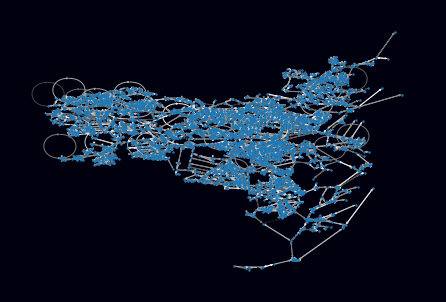

In [22]:
def plot_snow(G, graph, position):
    options = {
    "node_size": 2,
    "arrowsize": 3,
    "min_source_margin": 1,
    "pos": position
    }

    edge_color = []
    i = 0
    for edge in G.edges:
        snow = G.snow[edge]
        edge_clr = snow / 15
        if edge_clr > 1.0:
            edge_clr = 1.0
        edge_color.append((edge_clr, edge_clr, edge_clr))
        i += 1

    fig = plt.figure()
    nx.draw(graph, edge_color=edge_color, width=1, **options)
    fig.set_facecolor("#00000F")
    ##plt.savefig("imgs/" + name + "/" + name + "_" + subname + "_snow.png", dpi=1000)

position = get_position(directedNxGraph)

plot_snow(G, directedNxGraph, position)

Une fois tous ces calculs effectués, on va enlever de notre graphe les rues qui ne contiennent pas une quantité de neige suffisante pour faire se déplacer une déneigeuse. Cela nous permettra d'obtenir à la fin seulement le parcours de la déneigeuse, sans passage superflu. 

In [27]:
def remove_unsnowy(self):
        if self.directed == False:
            bridges = find_bridges_undirected(self.adj_list())
            if bridges == None:
                return
            for b in bridges:
                if b == None:
                    continue
                b1, b2 = b
                if ((b1, b2) in self.snow and self.snow[(b1, b2)] < 2.5):
                    continue
                elif ((b2, b1) in self.snow and self.snow[(b2, b1)] < 2.5):
                    continue

                w = 0
                for (a, b, w) in self.edges:
                    if (a == b1 and a == b2) or (a == b2 and a == b1):
                        self.edges.remove((a, b, w))

G.remove_unsnowy()
G.eulerize()
# find an eulerian cycle in a directed graph
cycle_directed = find_eulerian_cycle_directed(G.n, G.edges, 0)

# convert the node list to a directed graph (cycle graph)
G_cycle_directed = directed_graph_from_cycle(G.n, cycle_directed)

# convert it back to a nxgraph to plot it
E = directed_graph_to_nxgraph(G)



Et ça nous permet d’afficher cela :

In [29]:
plot_cycle(district, "directed_cycle", directedNxGraph, G_cycle_directed, E, G_nodes)

TypeError: object of type 'Graph' has no len()

Afin d’avoir une idée du coût du déneigement total de Montréal, nous avons choisi de mesurer trois indicateurs : le temps + coût en carburant pour une seule déneigeuse, pour une déneigeuse pour 2 quartiers et enfin pour une déneigeuse par quartier.

cout1
cout2
cout3


On peut clairement voir que le coût est moindre lorsque l’on a une déneigeuse par quartier, ce qui paraît logique. La déneigeuse seule met beaucoup trop de temps et le Soleil irait bien plus vite pour faire disparaître toute cette neige. Enfin la troisième solution, une déneigeuse pour deux quartiers, est efficace mais un peu lente et certains quartiers pourraient se retrouver défavoriser par rapport à d’autres. Il faudrait alors déneiger de nuit, et nous ne sommes pas sûrs que les déneigeurs québécois acceptent ces dures conditions de travail.


Pour arriver à ce travail final, nous sommes passés par plusieurs étapes et plusieurs cul de sac... Voici un petit tableau récapitulatif des techniques que nous avons testées, des résultats que nous avons obtenus grâce à ces dernières mais surtout de leurs limites.

![alt text](images/tableau.png "Tableau récapitulatif de nos essais")